# Obtenga con spark los datos (de forma ya agregada) que le permitan realizar la siguiente visualización y realice la misma (⭐⭐⭐)

![VISU](visu_del_ej25.png)

In [33]:
import pyspark as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import sqrt

In [34]:
spark = sp.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
rdd = spark.read.csv('../data/logs.csv', header=True, inferSchema=True).rdd

In [35]:
# [(0, 'item_id'),
#  (1, 'timestamp'),
#  (2, 'contributor_username'),
#  (3, 'contributor_id'),
#  (4, 'contributor_ip'),
#  (5, 'comment'),
#  (6, 'logtype'),
#  (7, 'action'),
#  (8, 'title')]

In [36]:
# Lista de acciones que me interesan.
acciones = ['autocreate', 'block', 'create', 'delete', 'move']

# Me quedo con los registros que tienen una de estas 5 acciones y son de usuarios registrados.
rdd = rdd.filter(lambda x: x[7] in acciones and x[2] and not x[4])

### Consigo un rdd con las acciones de cada usuario.

In [37]:
# i)  Marco la accion que hizo un usuario.
# ii) Sumo cuantas veces hizo cada accion.
rdd = rdd.map(lambda x: (x[2], (x[7].count('autocreate'), x[7].count('block'), x[7].count('create'), x[7].count('delete'), x[7].count('move'))))\
    .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3], x[4]+y[4]))\
    .cache()

# (usuario, cantidad: (autocreate, block, create, delete, move))

### Consigo la cantidad de usuarios.

In [38]:
cant_usuarios = rdd.count()
cant_usuarios

6114024

### Consigo el total de acciones.

In [39]:
total_acciones = rdd.map(lambda x: x[1][0]+x[1][1]+x[1][2]+x[1][3]+x[1][4]).sum()
total_acciones

12263825

### Consigo las medias de cada accion.

In [40]:
medias = rdd.map(lambda x: (x[1][0]/total_acciones, x[1][1]/total_acciones, x[1][2]/total_acciones, x[1][3]/total_acciones, x[1][4]/total_acciones))\
    .reduce(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3], x[4]+y[4]))

# medias: (autocreate, block, create, delete, move)
medias

(0.11161476945401365,
 0.02790540471671767,
 0.5957320004189528,
 0.19487199140561787,
 0.0698758340077424)

### Calculo la varianza de cada accion.

In [42]:
# Me guardo el estado del rdd para usarlo en el calculo de covarianzas.
rdd = rdd.map(lambda x: (x[0], (x[1][0]-medias[0], x[1][1]-medias[1], x[1][2]-medias[2], x[1][3]-medias[3], x[1][4]-medias[4])))\
    .cache()

In [45]:
varianzas = rdd.map(lambda x: ((acciones[0], (x[1][0]**2)/cant_usuarios),\
                               (acciones[1], (x[1][1]**2)/cant_usuarios),\
                               (acciones[2], (x[1][2]**2)/cant_usuarios),\
                               (acciones[3], (x[1][3]**2)/cant_usuarios),\
                               (acciones[4], (x[1][4]**2)/cant_usuarios)))

varianzas = varianzas.reduce(lambda x,y: ((x[0][0], x[0][1]+y[0][1]), (x[1][0], x[1][1]+y[1][1]), (x[2][0], x[2][1]+y[2][1]), (x[3][0], x[3][1]+y[3][1]), (x[4][0], x[4][1]+y[4][1])))

varianzas = dict(varianzas)
# (accion, varianza)

{'autocreate': 0.17376258911422338,
 'block': 481.3340211468227,
 'create': 6463.172471449107,
 'delete': 17430.469983401104,
 'move': 6355.783783281053}

### Transformo el rdd de forma que pueda hacer el producto cartesiano entre cada accion en cada usuario.

In [13]:
# Reparto cada registro del rdd en 5, uno por cada accion de cada usuario.
rdd = rdd.flatMap(lambda x: ((x[0], (acciones[0], x[1][0])),\
                             (x[0], (acciones[1], x[1][1])),\
                             (x[0], (acciones[2], x[1][2])),\
                             (x[0], (acciones[3], x[1][3])),\
                             (x[0], (acciones[4], x[1][4]))))

# (usuario, (accion, valor-su media))

### Calculo la covarianza entre cada par de acciones.

In [14]:
rdd = rdd.join(rdd)
# (usuario, ((accion1, valor1-su media), (accion2, valor2-su media)))

covarianzas = rdd.map(lambda x: ((x[1][0][0], x[1][1][0]), x[1][0][1]*x[1][1][1]))\
    .reduceByKey(lambda x,y: x+y)\
    .map(lambda x: (x[0], x[1]/cant_usuarios))\
    .takeOrdered(25, key=lambda x: acciones.index(x[0][0])*5 + acciones.index(x[0][1]))
    # Son en total 25 registros, por eso el takeOrdered(),
    # lo necesito ordenado para poder pasarlo a DF.

# ((accion1, accion2), covarianza)

### Broadcasteo varianzas

In [15]:
varianzasBC = sc.broadcast(varianzas)

### Calculo la correlacion entre las acciones.

In [16]:
correlaciones = sc.parallelize(covarianzas)\
    .map(lambda x: x[1]/sqrt(varianzasBC.value[x[0][0]]*varianzasBC.value[x[0][1]]))\
    .collect()

### Paso la lista a matriz.

In [17]:
matriz = list(correlaciones[i:i+5] for i in range(0,25,5))

### Paso la matriz a DataFrame de Pandas.

In [18]:
df = pd.DataFrame(matriz, index=acciones, columns=acciones)
df

,autocreate,block,create,delete,move
autocreate,1.000000,-0.000800,0.002007,-0.000964,0.000500
block,-0.000800,1.000000,0.048896,0.694568,0.052414
create,0.002007,0.048896,1.000000,0.070208,0.013665
delete,-0.000964,0.694568,0.070208,1.000000,0.083471
move,0.000500,0.052414,0.013665,0.083471,1.000000


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'autocreate'),
  Text(0, 1.5, 'block'),
  Text(0, 2.5, 'create'),
  Text(0, 3.5, 'delete'),
  Text(0, 4.5, 'move')])

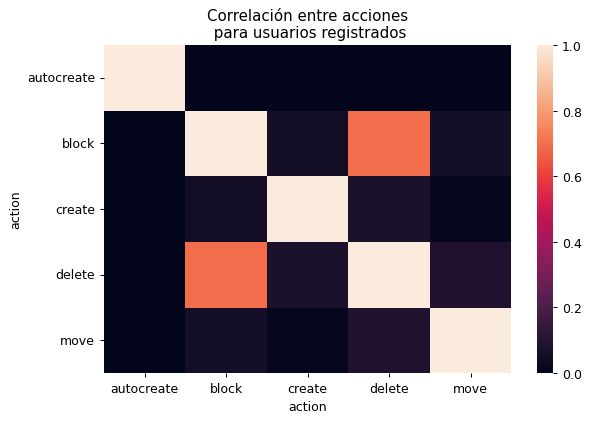

In [19]:
plt.figure(dpi=90)
sns.heatmap(df)
plt.title('Correlación entre acciones\n para usuarios registrados')
plt.xlabel('action')
plt.ylabel('action')
plt.tight_layout(w_pad=200)
plt.yticks(rotation=0)